<br/>

$$ \huge{\underline{\textbf{ Semi-Gradient TD }}} $$

<br/>

<img src="assets/0903b_Semi_Gradient_TD.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 9.3 </center>

<br/>

Implementation below matches the box exactly, but is for educational purposes only. Function approximator should be implemented as independent object - passing vector **w** around is impractical in actual program

In [1]:
def semi_gradient_TD(env, policy, ep, gamma, alpha, init_w, v_hat, grad_v_hat):
    """Semi-Gradient TD Algorithm
    
    Params:
        env        - environment
        policy     - function in a form: policy(state)->action
        ep         - number of episodes to run
        gamma      - discount [0..1]
        alpha      - step size (0..1]
        init_w     - function if form init_w() -> weights
        v_hat      - function in form v_hat(state, weights) -> float
        grad_v_hat - function in form grad_v_hat(state, weights) -> delta_weights
    """
    w = init_w()
        
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S)
            S_, R, done = env.step(A)
            w = w + alpha * (R + gamma * v_hat(S_, w) - v_hat(S, w)) * grad_v_hat(S, w)
            S = S_
            if done: break
    
    return w

Helper functions:

In [2]:
def init_w():
    return np.zeros(10)      # weights for 10 groups
        
def v_hat(St, w):
    if St in [0, 1001]: return 0    # return zero for terminal states
    group = (St-1) // 100           # [1-100, 101-200, ..., 901-1000] -> [0, 1, ..., 9]
    return w[group]
    
def grad_v_hat(St, w):
    grad = np.zeros_like(w)
    grad[(St-1)//100] = 1           # St=[1-100, ..., 901-1000] -> [0, ..., 9]
    return grad

For TD prediction to work, **V for terminal states must be equal to zero, always**. Value of terminal states is zero because game is over and there is no more reward to get. Value of next-to-last state is reward for last transition only, and so on. If not, then bad things will happen.

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0902a.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 9.2 (left) - "True" value is approximated with stright line<center/></td>
    </tr>
</table>

# Alternative Implementation

Object oriented implementation that treats function approximator as a black-box trainable model.

In [3]:
def semi_gradient_TD_fix(env, policy, ep, gamma, model):
    """Semi-Gradient TD Algorithm
    
    Params:
        env        - environment
        policy     - function in a form: policy(state)->action
        ep         - number of episodes to run
        gamma      - discount [0..1]
        model      - function approximator, already initialised, with method:
                     train(state, target) -> None
    """        
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S)
            S_, R, done = env.step(A)
            model.train(S, R + gamma * model.evaluate(S_))
            S = S_
            if done: break

Function approximator

In [4]:
class AggregateFunctApprox():
    """Very simple function approximator"""
    def __init__(self, learn_rate, nb_groups, group_size):
        self._lr = learn_rate
        self._nb_groups = nb_groups
        self._group_size = group_size
        self._w = np.zeros(nb_groups)  # weights
        
    def evaluate(self, state):
        if state <= 0 or state > self._nb_groups * self._group_size:
            return 0    # return zero for terminal states so TD works correctly
        group = (state-1) // self._group_size         # [1-100, ..., 901-1000] -> [0, ..., 9]
        return self._w[group]
    
    def train(self, state, target):        
        # Because grad_v_hat is a one-hot vector, we can optimize:
        group = (state-1) // self._group_size         # [1-100, ..., 901-1000] -> [0, ..., 9]
        self._w[group] += self._lr * (target - self._w[group])  # standard TD update!
        
        # Original impl., for reference:
        # w = w + alpha * (R + gamma * v_hat(S_, w) - v_hat(S, w)) * grad_v_hat(S, w)

# Evaluate Example 9.2 (left)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

Define environment, same as in example 9.1
* V_approx values were picked by trial-and-error, they ignore both nonlinearity and terminal states (which should equal zero)

In [6]:
class LinearEnv:
    """
    State nb:   [   0       1   ...   499   500   501   ...   1000    1001  ]
    State type: [terminal   .   ...    .   start   .    ...     .   terminal]
    """
    V_approx = np.arange(-1001, 1001, 2) / 1000.0  # ignore nonlinearity at terminal states
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self._state = 500
        self._done = False
        return self._state
        
    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
    
        if action == 0:   self._state -= np.random.randint(1, 101)  # step left
        elif action == 1: self._state += np.random.randint(1, 101)  # step right
        else: raise ValueError('Invalid action')
            
        self._state = np.clip(self._state, 0, 1001)  # clip to 0..1001
        if self._state in [0, 1001]:                 # both 0 and 1001 are terminal
            self._done = True
        
        if self._state == 0:
            return self._state, -1, self._done       # state, rew, done
        elif self._state == 1001:
            return self._state, 1, self._done
        else:
            return self._state, 0, self._done

Plotting

In [7]:
def plot_linear(V, env, freq=None, saveimg=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Note, state 0 is terminal, so we exclude it
    ax.plot(range(1,1001), env.V_approx[1:], color='red', linewidth=0.8, label='"True" value')
    ax.plot(range(1,1001), V[1:], color='blue', linewidth=0.8, label='Approx. MC value')
    ax.set_xlabel('State')
    ax.set_ylabel('Value Scale')
    ax.legend()
       
    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()    

Create environment

In [8]:
env = LinearEnv()

Random policy

In [9]:
def policy(st):
    return np.random.choice([0, 1])

Solve using original algorithm

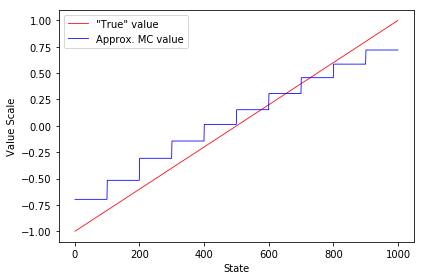

In [10]:
weights = semi_gradient_TD(env, policy, ep=1000, gamma=1., alpha=0.1,
                           init_w=init_w, v_hat=v_hat, grad_v_hat=grad_v_hat)
V = [v_hat(st, weights) for st in range(0,1001)]
plot_linear(V, env)

Solve using function approximator

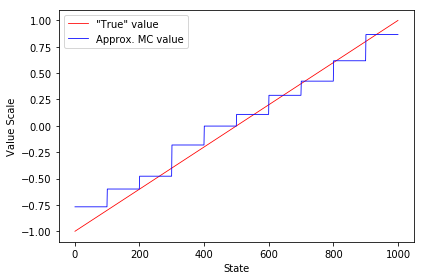

In [11]:
model = AggregateFunctApprox(learn_rate=0.1, nb_groups=10, group_size=100)
semi_gradient_TD_fix(env, policy, ep=1000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env)

# Recreate Figure 9.2 (left)

In [12]:
weights = semi_gradient_TD(env, policy, ep=10000, gamma=1., alpha=0.001,
                           init_w=init_w, v_hat=v_hat, grad_v_hat=grad_v_hat)
V = [v_hat(st, weights) for st in range(1001)]

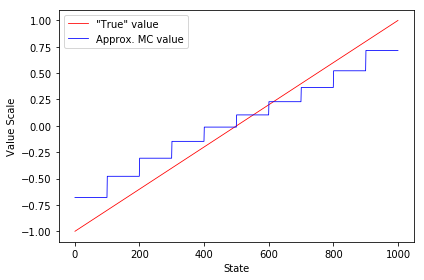

In [13]:
plot_linear(V, env, saveimg=None)  # 'assets/fig_0903b'